In [44]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import cvxpy as cp
import time

Aggressive and Defensive portfolios
This is a fairly well-diversified selection — spanning IT, Energy, Banking, Pharma, FMCG,etc.

In [45]:
aggressive_tickers = ["TSLA", "RELIANCE.NS", "INDA","AAPL","NVDA","QQQ","ARKK","META"]
defensive_tickers = ["WMT", "GLD", "CIPLA.NS", "SBILIFE.NS","TLT","VNQ","XLU","MCD"]

Training dates

In [46]:
start_date = "2019-04-01"
end_date = "2022-03-31"

Function to load the data

In [47]:
def download_price_and_returns(tickers, start_date, end_date):
    all_closes = pd.DataFrame()
    for ticker in tickers:
        try:
            print(f"Downloading {ticker}...")
            data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)['Close']
            all_closes[ticker] = data
        except Exception as e:
            print(f"Failed to download {ticker}: {e}")
    
    returns = all_closes.pct_change().dropna()
    return all_closes, returns

Testing dates

In [48]:
start_date2 = "2022-04-01"
end_date2 = "2025-03-31"

Markowitz Optimization

We have split our optimization into two parts one for the aggressive and one for the defensive tickers , aiming at good returns and low volatility.

Defensive Optimizer

In [49]:
def def_markowitz_optimizer(mean_returns, cov_matrix, target_returns, weight_bounds=(0.0,0.33), risk_free_rate=0.06):
    n_assets = len(mean_returns)
    weights = cp.Variable(n_assets)
    portfolio_risk = cp.quad_form(weights, cov_matrix)
    portfolio_return = mean_returns.values @ weights

    results = {
        'risks': [],
        'weights': [],
        'sharpe_ratios': [],
    }

    for target in target_returns:
        constraints = [
            cp.sum(weights) == 1,
            weights >= weight_bounds[0],
            weights <= weight_bounds[1],
            portfolio_return >= target
        ]
        prob = cp.Problem(cp.Minimize(portfolio_risk), constraints)
        prob.solve()

        if weights.value is not None:
            w = weights.value
            vol = np.sqrt(w.T @ cov_matrix.values @ w)
            ann_return = mean_returns.values @ w * 252
            sharpe = (ann_return - risk_free_rate) / vol
            results['risks'].append(vol)
            results['weights'].append(w)
            results['sharpe_ratios'].append(sharpe)

    idx_best = int(np.argmax(results['sharpe_ratios']))
    return results, idx_best

Aggressive Optimizer

In [50]:
def agg_markowitz_optimizer(mean_returns, cov_matrix, target_returns, weight_bounds=(0, 0.3), risk_free_rate=0.06):
    n_assets = len(mean_returns)
    weights = cp.Variable(n_assets)
    portfolio_risk = cp.quad_form(weights, cov_matrix)
    portfolio_return = mean_returns.values @ weights

    results = {
        'risks': [],
        'weights': [],
        'sharpe_ratios': [],
    } 

    for target in target_returns:
        constraints = [
            cp.sum(weights) == 1,
            weights >= weight_bounds[0],
            weights <= weight_bounds[1],
            portfolio_return >= target
        ]
        prob = cp.Problem(cp.Maximize(portfolio_return), constraints)
        prob.solve()

        if weights.value is not None:
            w = weights.value
            vol = np.sqrt(w.T @ cov_matrix.values @ w)
            ann_return = mean_returns.values @ w * 252
            sharpe = (ann_return - risk_free_rate) / vol
            results['risks'].append(vol)
            results['weights'].append(w)
            results['sharpe_ratios'].append(sharpe)

    idx_best = int(np.argmax(results['sharpe_ratios']))
    return results, idx_best

Aggressive portfolio

In [51]:
agg_data, agg_returns = download_price_and_returns(aggressive_tickers, start_date, end_date)
agg_mean = agg_returns.mean()
agg_cov = agg_returns.cov()
agg_results, agg_best_index = agg_markowitz_optimizer(agg_mean, agg_cov, np.linspace(agg_mean.min(), agg_mean.max(), 50))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\arshc\AppData\Local\Temp\ipykernel_12632\1025574677.py:11: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



Defensive portfolio

In [52]:
def_data, def_returns = download_price_and_returns(defensive_tickers, start_date, end_date)
def_mean = def_returns.mean()
def_cov = def_returns.cov()
def_results, def_best_index = def_markowitz_optimizer(def_mean, def_cov, np.linspace(def_mean.min(), def_mean.max(), 50))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\arshc\AppData\Local\Temp\ipykernel_12632\1025574677.py:11: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



Weight Splits(agg & def separately)

In [53]:
agg_optimal_weights = agg_results['weights'][agg_best_index]
print("Optimal Portfolio Weights:")
print(dict(zip(aggressive_tickers, np.round(agg_optimal_weights, 4))))
def_optimal_weights = def_results['weights'][def_best_index]
print("Optimal Portfolio Weights:")
print(dict(zip(defensive_tickers, np.round(def_optimal_weights, 4))))

Optimal Portfolio Weights:
{'TSLA': np.float64(0.3), 'RELIANCE.NS': np.float64(0.1), 'INDA': np.float64(0.0), 'AAPL': np.float64(0.3), 'NVDA': np.float64(0.3), 'QQQ': np.float64(0.0), 'ARKK': np.float64(0.0), 'META': np.float64(0.0)}
Optimal Portfolio Weights:
{'WMT': np.float64(0.2496), 'GLD': np.float64(0.33), 'CIPLA.NS': np.float64(0.1948), 'SBILIFE.NS': np.float64(0.2246), 'TLT': np.float64(0.001), 'VNQ': np.float64(-0.0), 'XLU': np.float64(-0.0), 'MCD': np.float64(-0.0)}


Testing

In [54]:
def backtest_portfolio(returns_df, weights, initial_capital=100000, annual_risk_free_rate=0.06):
    # 1. Daily portfolio returns
    portfolio_daily_returns = returns_df @ weights

    # 2. Portfolio value over time
    portfolio_value = (1 + portfolio_daily_returns).cumprod() * initial_capital

    # 3. Performance metrics
    total_return = portfolio_value.iloc[-1] / initial_capital - 1
    annualized_return = (1 + total_return) ** (1/3) - 1  # 3-year period
    annualized_volatility = portfolio_daily_returns.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - annual_risk_free_rate) / annualized_volatility

    metrics = {
        "Total Return": total_return,
        "Annualized Return": annualized_return,
        "Annualized Volatility": annualized_volatility,
        "Sharpe Ratio": sharpe_ratio
    }

    return portfolio_value, metrics

In [55]:
agg_weights = agg_results['weights'][agg_best_index]
def_weights = def_results['weights'][def_best_index]

Get test returns for 2022–2025

In [56]:
agg_test_data, agg_test_returns = download_price_and_returns(aggressive_tickers, start_date2, end_date2)
def_test_data, def_test_returns = download_price_and_returns(defensive_tickers, start_date2, end_date2)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
C:\Users\arshc\AppData\Local\Temp\ipykernel_12632\1025574677.py:11: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
C:\Users\arshc\AppData\Local\Temp\ipykernel_12632\1025574677.py:11: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



Backtest 

In [57]:
agg_value, agg_metrics = backtest_portfolio(agg_test_returns, agg_weights, initial_capital=8000)
def_value, def_metrics = backtest_portfolio(def_test_returns, def_weights, initial_capital=92000)

In [58]:
combined_tickers = aggressive_tickers + defensive_tickers
combined_weights = list(0.08 * np.array(agg_weights)) + list(0.92 * np.array(def_weights))

In [59]:
combined_returns = pd.concat([agg_test_returns, def_test_returns], axis=1)

In [60]:
combined_tickers = aggressive_tickers + defensive_tickers
combined_returns.columns = combined_tickers

In [61]:
print("\nBacktest Performance:")
combined_value, combined_metrics = backtest_portfolio(combined_returns, combined_weights, initial_capital=100000)


Backtest Performance:


In [62]:
print("----- Combined Portfolio Metrics -----")
for key, value in combined_metrics.items():
    print(f"{key}: {value}")

----- Combined Portfolio Metrics -----
Total Return: 0.6550467182190884
Annualized Return: 0.1828692786142474
Annualized Volatility: 0.10765288827672423
Sharpe Ratio: 1.1413467913504474


plot results

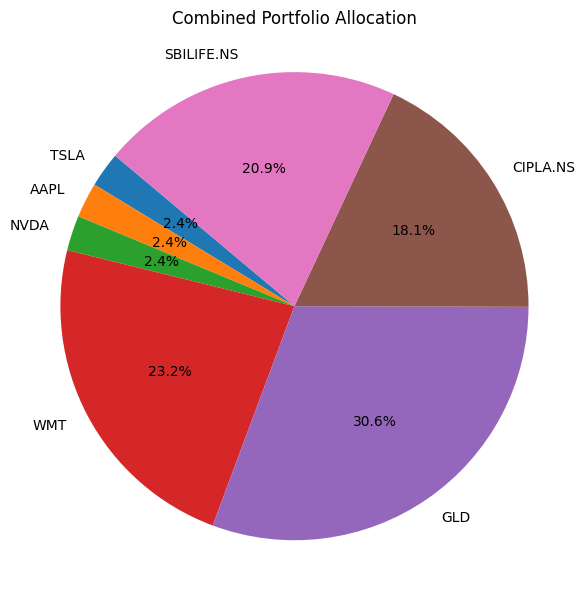

In [63]:
# 1. Pie Chart
plt.figure(figsize=(6, 6))
final_weights = np.array(combined_weights)
labels = [t for t, w in zip(combined_tickers, final_weights) if w > 0.02]
sizes = [w for w in final_weights if w > 0.02]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Combined Portfolio Allocation")
plt.axis('equal')
plt.tight_layout()
plt.show()

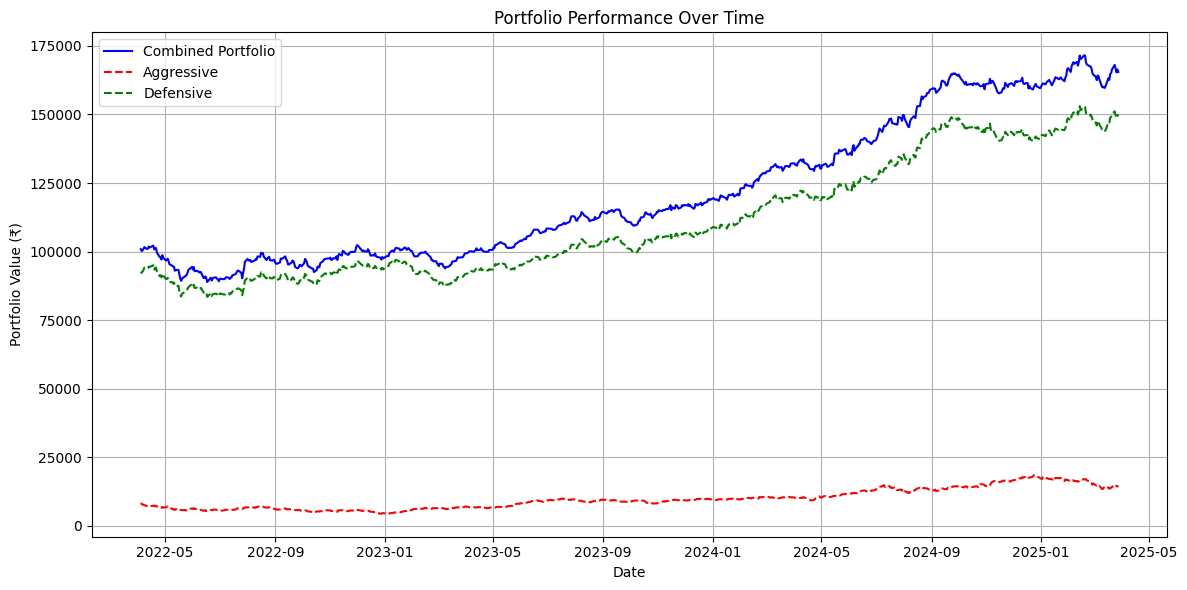

In [64]:
# 2. Portfolio Value Over Time
plt.figure(figsize=(12, 6))
plt.plot(combined_value.index, combined_value.values, label='Combined Portfolio', color='blue')
plt.plot(agg_value.index, agg_value.values, label='Aggressive', linestyle='--', color='red')
plt.plot(def_value.index, def_value.values, label='Defensive', linestyle='--', color='green')
plt.title("Portfolio Performance Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (₹)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [65]:
# 3. Bar Chart for Allocations
alloc_inr = np.array(combined_weights) * 100000
tickers_inr = [t for t, w in zip(combined_tickers, alloc_inr) if w > 100]
allocs = [w for w in alloc_inr if w > 100]

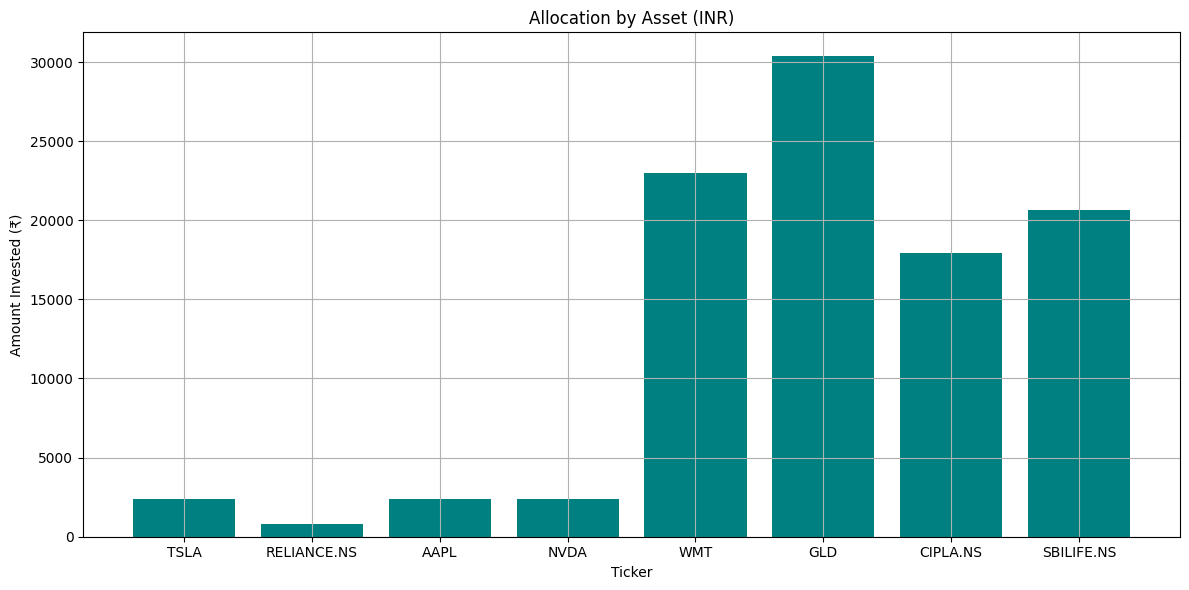

In [66]:
plt.figure(figsize=(12, 6))
plt.bar(tickers_inr, allocs, color='teal')
plt.title("Allocation by Asset (INR)")
plt.xlabel("Ticker")
plt.ylabel("Amount Invested (₹)")
plt.grid(True)
plt.tight_layout()
plt.show()